# Results 2c: Metric Validation

In [1]:
import os
import numpy as np
from pandas import read_csv
from tqdm import tqdm

## Section 1: Load and prepare data

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load data.
scores = read_csv(os.path.join('data','scores.csv'))
items = read_csv(os.path.join('data','items.csv'))

## Restrict participants.
metrics = read_csv(os.path.join('data', 'metrics.csv'))
scores = scores[scores.subject.isin(metrics.subject)].reset_index(drop=True)
items = items[items.subject.isin(metrics.subject)].reset_index(drop=True)

## Merge DataFrames.
data = items.merge(scores).merge(metrics[['platform','subject','infreq']])

## Re-format infrequency.
data['infreq'] = np.where(data['infreq'] > 0, 1, 0)

## Compute binarized SHAPS scores.
data['shaps_binarized'] = np.where(data.filter(regex='shaps_') >= 2, 1, 0).sum(axis=1)

## Section 2: Total Symptom Scores

In [3]:
from scipy.stats import ttest_ind
from numba import njit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
order = ['7u','7d','gad7','bis','bas','shaps','pswq']

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
tvals, pvals = np.zeros((2,len(order)))

## Iteratively compute test statistics.
for i, col in enumerate(order):
    tvals[i], _ = ttest_ind(data.loc[data.infreq==0, col], data.loc[data.infreq==1, col])
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space
null_tvals = np.zeros((n_iter, len(order)))

## Main loop.
permuted = data.copy()
for n in tqdm(range(n_iter)):
    
    ## Permute rows of infrequncy score.
    permuted.infreq = np.random.permutation(permuted.infreq)
    
    ## Iteratively compute test statistics.
    for i, col in enumerate(order):
        null_tvals[n,i], _ = ttest_ind(permuted.loc[permuted.infreq==0, col], 
                                       permuted.loc[permuted.infreq==1, col])
        
## Compute p-values.
for i in range(len(order)):
    pvals[i] = ((np.abs(tvals[i]) <= np.abs(null_tvals[:,i])).sum() + 1) / (n_iter + 1)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

for i, col in enumerate(order):
    print('%s\t tval = %0.3f\tpval = %0.3f' %(col, tvals[i], pvals[i]))

100%|██████████| 5000/5000 [00:33<00:00, 149.27it/s]

7u	 tval = -13.312	pval = 0.000
7d	 tval = -9.987	pval = 0.000
gad7	 tval = -7.881	pval = 0.000
bis	 tval = -0.542	pval = 0.612
bas	 tval = -0.912	pval = 0.357
shaps	 tval = -4.043	pval = 0.000
pswq	 tval = -4.784	pval = 0.000


## Section 3: Cronbach's Alpha

In [4]:
from scipy.stats import ttest_rel
from numba import njit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
order = ['7u','7d','gad7','bis','bas','shaps','pswq']

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

@njit
def cronbach_alpha(X):
    "Estimate Cronbach's alpha for X, [n_obs, n_features]"
    n, k = X.shape
    C = np.cov(X.T)
    return (k / (k - 1)) * (1 - np.trace(C) / np.sum(C))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
alpha_0 = np.zeros(len(order))
alpha_1 = np.zeros(len(order))

## Iteratively compute Cronbach's alpha.
for i, subscale in enumerate(order):
    cols = items.filter(regex=f'{subscale}_').columns
    alpha_0[i] = cronbach_alpha(data.loc[data.infreq==0,cols].values)
    alpha_1[i] = cronbach_alpha(data.loc[data.infreq==1,cols].values)
    
## Compute test statistic.
tval, _ = ttest_rel(alpha_0, alpha_1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space
null_tvals = np.zeros(n_iter)

## Main loop.
permuted = data.copy()
for n in tqdm(range(n_iter)):
    
    ## Preallocate space.
    alpha_null = np.zeros((2, len(order))) 
    
    ## Permute rows of infrequncy score.
    permuted.infreq = np.random.permutation(permuted.infreq)
    
    ## Iteratively compute Cronbach's alpha.
    for i, subscale in enumerate(order):
        cols = items.filter(regex=f'{subscale}_').columns
        alpha_null[0,i] = cronbach_alpha(permuted.loc[permuted.infreq==0,cols].values)
        alpha_null[1,i] = cronbach_alpha(permuted.loc[permuted.infreq==1,cols].values)
        
    ## Compute test statistic.
    null_tvals[n], _ = ttest_rel(alpha_null[0], alpha_null[1])
    
## Compute p-value.
pval = ((np.abs(tval) <= np.abs(null_tvals)).sum() + 1) / (n_iter + 1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Report statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Report Cronbach's alpha.
print('Attentive:', alpha_0.round(3))
print('Careless:', alpha_1.round(3))

## Compute effect size.
dval = np.mean(alpha_0 - alpha_1) / np.std(alpha_0 - alpha_1)

## Compute confidence interval.
lb = np.mean(alpha_0 - alpha_1) - 1.96 * np.std(alpha_0 - alpha_1) / np.sqrt(alpha_0.size)
ub = np.mean(alpha_0 - alpha_1) + 1.96 * np.std(alpha_0 - alpha_1) / np.sqrt(alpha_0.size)

## Report permutation test results.
print('t(%s) = %0.3f, p = %0.3f, d = %0.3f, 95%% CI = [%0.3f, %0.3f]' %(alpha_0.size-1, tval, pval, dval, lb, ub))

100%|██████████| 5000/5000 [01:14<00:00, 67.22it/s]

Attentive: [0.836 0.937 0.924 0.83  0.843 0.904 0.934]
Careless: [0.838 0.882 0.872 0.624 0.712 0.812 0.807]
t(6) = 3.689, p = 0.021, d = 1.506, 95% CI = [0.048, 0.141]


## Section 4: Rates of Clinical Endorsement 

In [5]:
from pandas import DataFrame
from scipy.stats import skew

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define clinical cutoffs.
cutoffs = {
    '7u':12, 
    '7d':12, 
    'gad7':10, 
    'bis':np.nan, 
    'bas':np.nan, 
    'shaps':3, 
    'pswq':11
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute summary statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
table = np.zeros((len(order), 9))

## Iteratively compute summary statistics.
for i, (k, v) in enumerate(cutoffs.items()):
    
    ## Compute skew of score distribution.
    table[i,0] = skew(data[k])
    
    ## Compute total scores.
    table[i,1:3] = data.groupby('infreq')[k].mean()
    
    ## Compute proportion at threshold.
    if k == 'shaps': k = 'shaps_binarized'
    table[i,7] = np.round((data[k] >= v).mean() * 100, 1)
    table[i,8] = np.round((data.query('infreq == 0')[k] >= v).mean() * 100, 1)
        
## Store Cronbach alpha.
table[:,3] = tvals
table[:,4] = pvals
table[:,5] = alpha_0
table[:,6] = alpha_1

## Convert to DataFrame.
table = DataFrame(table, index=['7-up','7-down','GAD-7','BIS','BAS','SHAPS','PSWQ'],
                  columns=['Skew','Score-A','Score-C','Score-T','Score-P',
                           'Alpha-A','Alpha-C','Cutoff-A','Cutoff-C'])

## Format DataFrame.
for col, fmt in zip(table.columns, [3,1,1,3,3,2,2,1,1]):
    table[col] = [f'%0.{fmt}f' %x if x else '-' for x in table[col]]

## Print LaTeX.
print(table.to_latex())

<ipython-input-5-90ca490382be>:56: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(table.to_latex())


\begin{tabular}{llllllllll}
\toprule
{} &   Skew & Score-A & Score-C &  Score-T & Score-P & Alpha-A & Alpha-C & Cutoff-A & Cutoff-C \\
\midrule
7-up   &  0.806 &     3.9 &    10.2 &  -13.312 &   0.000 &    0.84 &    0.84 &     13.0 &      4.0 \\
7-down &  0.759 &     4.8 &    10.7 &   -9.987 &   0.000 &    0.94 &    0.88 &     17.4 &      9.3 \\
GAD-7  &  0.753 &     4.9 &     9.7 &   -7.881 &   0.000 &    0.92 &    0.87 &     25.9 &     17.3 \\
BIS    &  0.780 &     7.7 &     7.9 &   -0.542 &   0.612 &    0.83 &    0.62 &        - &        - \\
BAS    &  0.171 &    15.7 &    16.2 &   -0.912 &   0.357 &    0.84 &    0.71 &        - &        - \\
SHAPS  &  0.256 &     8.0 &    10.8 &   -4.043 &   0.000 &    0.90 &    0.81 &     17.9 &     14.6 \\
PSWQ   &  0.193 &     4.8 &     6.7 &   -4.784 &   0.000 &    0.93 &    0.81 &      7.3 &      7.0 \\
\bottomrule
\end{tabular}



## Section 5: 1-PL model w/ Random Intercepts

#### 5.1: Load and prepare data

In [6]:
from pandas import read_csv
from arviz import hdi

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load StanFit summary.
f = os.path.join('stan_results','1pl_logistic.tsv.gz')
df = read_csv(f, sep='\t', compression='gzip')

## Extract random intercepts.
intercepts = df.filter(regex='Z\[[0-9]*,1\]').mean().values

## Extract contrast statistics.
contrasts = df.filter(regex='contrasts')

## Compute contrast statistics.
f = lambda arr: hdi(arr.values, hdi_prob=0.95)
mu = contrasts.mean()
lb, ub = contrasts.apply(f).values

## Print contrast statistics.
print('Attentive: %0.3f' %mu[0])
print('Careless: %0.3f' %mu[1])
print('Contrast: %0.3f 95%% hdi = [%0.3f, %0.3f]' %(mu[2], lb[2], ub[2]))

Attentive: -0.175
Careless: 0.491
Contrast: -0.665 95% hdi = [-0.778, -0.554]


#### 5.2 Plotting

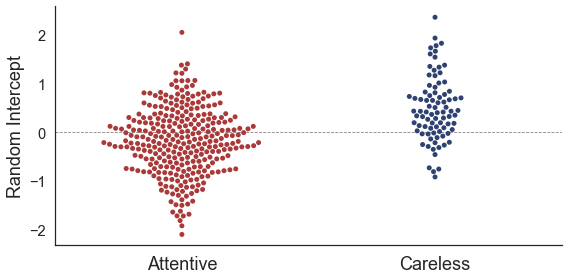

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme('notebook', style='white', font='sans-serif', font_scale=1.33)
%matplotlib inline

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Define aesthetics.
palette = ['#AA3939','#2E4272']

## Plot distribution of intercepts.
ax = sns.swarmplot(x=data.infreq.values, y=intercepts, palette=palette, ax=ax)
ax.axhline(0, lw=0.8, linestyle='--', color='0.5', zorder=-1)

## Add details.
ax.set_xticklabels(['Attentive','Careless'], fontsize=18)
ax.set_ylabel('Random Intercept', fontsize=18)

sns.despine()
plt.tight_layout()